<a href="https://colab.research.google.com/github/petergchang/sarkka-jax/blob/main/Ch7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#7. Particle Filtering

This notebook replicates the figures of Chapter 7 of Särkkä's "Bayesian Filtering and Smoothing" using JAX.

Simo Särkkä (2013), “Bayesian Filtering and Smoothing,” Cambridge University Press. Available: https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf

This JAX translation is by Peter G. Chang ([@petergchang](https://github.com/petergchang))

##7.0 Imports and Pendulum Simulation

In [87]:
%matplotlib inline

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax
import matplotlib.pyplot as plt

In [88]:
# Function to simulate pendulum
def simulate_pendulum(key, m_0, f, Q, h, r, steps):
    def _step(carry, rng):
        state = carry
        rng1, rng2 = jr.split(rng, 2)
        next_state = f(state) + jr.multivariate_normal(rng1, jnp.zeros(M), Q)
        obs = h(next_state) + jr.normal(rng2) * r
        return next_state, (next_state, obs)

    M = m_0.shape[-1]
    state = m_0
    rngs = jr.split(key, steps)
    _, (states, observations) = lax.scan(
        _step, state, rngs
    )
    return states, observations

In [89]:
# Params for pendulum simulation
key = jr.PRNGKey(0)
m_0 = jnp.array([[jnp.pi/2, 0]])
dt = 0.0125
q = 1
g = 9.8
Q = jnp.array([[q*dt**3/3, q*dt**2/2],
               [q*dt**2/2,      q*dt]])
r = 0.3
f = lambda x: jnp.array([[x[0,0] + x[0,1]*dt, x[0,1] - g*jnp.sin(x[0,0])*dt]])
h = lambda x: jnp.array([jnp.sin(x[0,0])])

# Simulate pendulum angle
states, obs = simulate_pendulum(key, m_0, f, Q, h, r, 400)

# # Apply arcsin to measured horizontal position to compute measured angle
# obs_angle = jnp.arcsin(jnp.clip(obs[:,0], -1, 1)) 

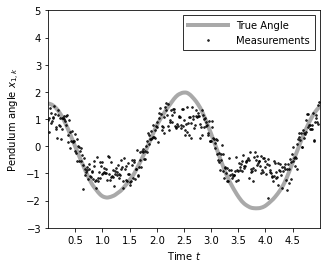

In [90]:
# Create time grid for plotting
time_grid = jnp.arange(0.0, 5.0, step=dt)

# Plot the generated data
plt.figure()
plt.plot(time_grid, states[:,0,0], color='darkgray', linewidth=4, label="True Angle")
plt.plot(time_grid, obs, 'ok', fillstyle='none', ms=1.5, label='Measurements')
# plt.plot(m_kf[:,0], m_kf[:,1], color='k', linewidth=1.5, label="Filter Estimate")
plt.xlabel('Time $t$'); plt.ylabel('Pendulum angle $x_{1,k}$')
plt.xlim(0, 5); plt.ylim(-3, 5)
plt.xticks(jnp.arange(0.5, 4.6, 0.5))
plt.yticks(jnp.arange(-3, 5.1, 1))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

##7.4 Sequential Importance Resampling

In [72]:
from jax.scipy.stats import multivariate_normal

# Bootstrap Particle Filter (Algorithm 7.5)
def bootstrap_pf(key, m_0, P_0, f, h, Q, R, Y, n_particles):
    def _step(carry, rng_t):
        key, t = rng_t
        weights, particles = carry
        key, subkey = jr.split(key, 2)

        # 1. Draw new points from (Gaussian) dynamic model
        m_pred = jax.vmap(f, 0, 0)(particles)
        keys_pred = jr.split(key, n_particles)
        normal_sample_vec = jax.vmap(jr.multivariate_normal, (0, 0, None), 0)
        particles_pred = normal_sample_vec(keys_pred, m_pred, Q)

        # 2. Calculate the weights from (Gaussian) measurement model
        obs_pred = jax.vmap(h, 0, 0)(particles_pred)
        normal_pdf_vec = jax.vmap(multivariate_normal.pdf, (None, 0, None), 0)
        weights_post = normalize(normal_pdf_vec(Y[t], obs_pred, R), -1)

        # 3. Perform resampling
        weights_post, particles_post = resample(subkey, weights_post, particles_pred)
        
        return (weights_post, particles_post), (weights_post, particles_post)

    def resample(key, weights, particles):
        idx = jr.categorical(key, jnp.log(weights), shape=(n_particles,))
        weights_post = jnp.ones(n_particles) / n_particles
        return weights_post, particles[idx]
    
    def normalize(weights, axis):
        return weights / jnp.sum(weights, axis=axis, keepdims=True)

    num_timesteps = len(Y)
    
    # Prior (Gaussian) particles and (uniform) weights
    key, subkey = jr.split(key, 2)
    particles = jr.multivariate_normal(key, m_0, P_0, shape=(n_particles,1))
    weights = jnp.ones(n_particles)/n_particles

    rngs = jr.split(subkey, num_timesteps)
    carry = (weights, particles)
    _, (ws, ps) = lax.scan(
        _step, carry, (rngs, jnp.arange(num_timesteps))
    )
    return ws, ps

In [73]:
key, subkey = jr.split(key, 2)
P_0 = jnp.eye(m_0.shape[-1])*0.1
n_particles = 2000
_, particles_pf = bootstrap_pf(key, m_0, P_0, f, h, Q, r, obs, n_particles)
m_pf = jnp.mean(particles_pf, axis=1)

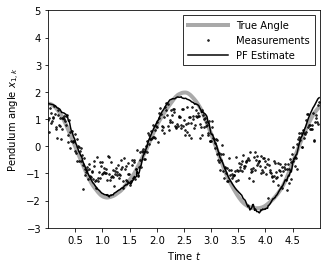

In [74]:
# Plot the generated data (Replicates Figure 7.3)
plt.figure()
plt.plot(time_grid, states[:,0,0], color='darkgray', linewidth=4, label="True Angle")
plt.plot(time_grid, obs, 'ok', fillstyle='none', ms=1.5, label='Measurements')
plt.plot(time_grid, m_pf[:,0,0], color='k', linewidth=1.5, label="PF Estimate")
plt.xlabel('Time $t$'); plt.ylabel('Pendulum angle $x_{1,k}$')
plt.xlim(0, 5); plt.ylim(-3, 5)
plt.xticks(jnp.arange(0.5, 4.6, 0.5))
plt.yticks(jnp.arange(-3, 5.1, 1))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

We compute the RMSE of the PF estimate.

In [75]:
# Helper function to compute RMSE
def compute_rmse(y, y_est):
    num_samples = y.shape[0]
    return jnp.sqrt(jnp.sum((y-y_est)**2)/num_samples)

# Compute RMSE of the EKF estimate
rmse_pf = compute_rmse(states[:,0,0], m_pf[:,0,0])

print(f'The RMSE of the PF estimate of the angle is: {rmse_pf:.2f},')
print(f'The standard deviation of measurement noise is: {jnp.sqrt(r):.2f}')

The RMSE of the PF estimate of the angle is: 0.14,
The standard deviation of measurement noise is: 0.55


Next, to replicate Figure 7.4, we generate clutter (outlier) pendulum measurements.

We generate such clutter by generating a random number in the range [-2, 2] with probability 50% at each time step.

In [91]:
states.shape

(400, 1, 2)

In [92]:
# Function to simulate pendulum
def simulate_pendulum_clutter(key, h, r, states, c_range, c_prob):
    def clutter(state, rng):
        key1, key2, key3 = jr.split(rng, 3)
        # Uncluttered observation
        obs_u = h(state) + jr.normal(key1) * r
        # # Cluttered observation
        obs_c = jnp.array([jr.uniform(key2, minval=-c_range, maxval=c_range)])
        # Clutter with probability c_prob
        obs = jr.choice(key3, jnp.array([obs_u, obs_c]), 
                        p=jnp.array([c_prob, 1-c_prob]))
        return obs

    steps = states.shape[0]
    rngs = jr.split(key, steps)
    clutter_vec = jax.vmap(clutter, (0, 0), 0)
    return clutter_vec(states, rngs)

In [94]:
key = jr.PRNGKey(0)
# Simulate cluttered pendulum angle
obs_c = simulate_pendulum_clutter(key, h, r, states, 2, 0.5)

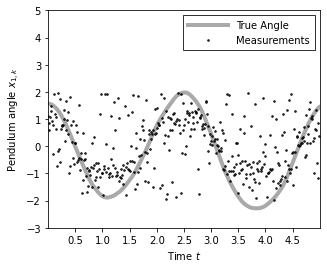

In [95]:
# Create time grid for plotting
time_grid = jnp.arange(0.0, 5.0, step=dt)

# Plot the generated data
plt.figure()
plt.plot(time_grid, states[:,0,0], color='darkgray', linewidth=4, label="True Angle")
plt.plot(time_grid, obs_c, 'ok', fillstyle='none', ms=1.5, label='Measurements')
# plt.plot(m_kf[:,0], m_kf[:,1], color='k', linewidth=1.5, label="Filter Estimate")
plt.xlabel('Time $t$'); plt.ylabel('Pendulum angle $x_{1,k}$')
plt.xlim(0, 5); plt.ylim(-3, 5)
plt.xticks(jnp.arange(0.5, 4.6, 0.5))
plt.yticks(jnp.arange(-3, 5.1, 1))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

Next, we borrow the GHKF implementation from Ch.6 for comparison with the particle filter.